Let's see what's up with finite sampling and the variance it introduces.

The variance may vary based on kernel value!

In [1]:
import pickle
import pandas as pd
from itertools import chain
from pathlib import Path
import qiskit_machine_learning
import sys
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
from tqdm import tqdm
tqdm.pandas()

sys.path.append('../code')

from utils import compute_additional_fields

In [2]:
def get_lower_triangle_one(x):
    return x[np.tril_indices(x.shape[0], k=-1)].flatten()

def get_lower_triangle(matrices):
    return np.array([get_lower_triangle_one(x) for x in matrices])

def get_symmetric_random_no_diagonal(std, size):
    """Returns symmetric matrix with 0 on diagonal
    and the rest distributed normally around 0 with a given std
    """
    lt = np.tril(np.random.normal(loc=0, scale=std, size=size), k=-1)
    return lt + lt.T

def enforce_psd(kernel):
    D, U = np.linalg.eig(kernel)  # pylint: disable=invalid-name  
    return U @ np.diag(np.maximum(0, D)) @ U.transpose()

pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy'
}

In [3]:
scaling_factor2kernel_std_train = {}
scaling_factor2kernel_std_test = {}

for fname in Path("../data/results/test_sampling_noise/").glob("*.p"):
    row = pickle.load(open(fname,'rb'))
    row.update(vars(row['args']))
    matrices_train = get_lower_triangle(row['qkern_matrices_train'])
    matrices_test = get_lower_triangle(row['qkern_matrices_test'])
    scaling_factor2kernel_std_train[row['evo_time']] = np.mean(np.std(matrices_train, axis=0))
    scaling_factor2kernel_std_test[row['evo_time']] = np.mean(np.std(matrices_test, axis=0))

In [4]:
recompute = True
if recompute:
    all_res = []

    for fname in tqdm(Path("../data/results/test_limited_precision/").glob("*.p")):
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        res['qkern_matrix_train'] += get_symmetric_random_no_diagonal(
            scaling_factor2kernel_std_train[row['evo_time']], res['qkern_matrix_train'].shape)
        K_new = enforce_psd(deepcopy(res['qkern_matrix_train']))
        res['frob norm K-enforce_psd(K)/norm K'] = np.linalg.norm(K_new - res['qkern_matrix_train'])/np.linalg.norm(res['qkern_matrix_train'])
        res['qkern_matrix_train'] = K_new

        res['qkern_matrix_test'] += np.random.normal(
            loc=0, scale=scaling_factor2kernel_std_test[row['evo_time']], size=res['qkern_matrix_test'].shape)
        all_res.append(res)

    df_all_limited_precision_sampling = pd.DataFrame(all_res, columns=all_res[0].keys())

    dataset_name = set(df_all_limited_precision_sampling['dataset'])
    assert(len(dataset_name) == 1)
    dataset_name = dataset_name.pop()
    df_all_limited_precision_sampling = compute_additional_fields(df_all_limited_precision_sampling, dataset_name=dataset_name)

    all_res = []

    for fname in Path("../data/results/test_limited_precision/").glob("*.p"):
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all_limited_precision_no_sampling = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all_limited_precision_no_sampling = compute_additional_fields(df_all_limited_precision_no_sampling, dataset_name='fashion-mnist')

    all_res = []

    for fname in tqdm(Path(f"../data/results/control_evo_time/").glob("dim_19_ntrot_40_evo_t_*.p")):
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        res['qkern_matrix_train'] += get_symmetric_random_no_diagonal(
            scaling_factor2kernel_std_train[row['evo_time']], res['qkern_matrix_train'].shape)
        K_new = enforce_psd(deepcopy(res['qkern_matrix_train']))
        res['frob norm K-enforce_psd(K)/norm K'] = np.linalg.norm(K_new - res['qkern_matrix_train'])/np.linalg.norm(res['qkern_matrix_train'])
        res['qkern_matrix_train'] = K_new

        res['qkern_matrix_test'] += np.random.normal(
            loc=0, scale=scaling_factor2kernel_std_test[row['evo_time']], size=res['qkern_matrix_test'].shape)
        all_res.append(res)

    df_all_sampling = pd.DataFrame(all_res, columns=all_res[0].keys())

    df_all_sampling = compute_additional_fields(df_all_sampling, dataset_name="fashion-mnist")

    all_res = []

    for fname in Path(f"../data/results/control_evo_time/").glob("dim_19_ntrot_40_evo_t_*.p"):
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all_no_sampling = pd.DataFrame(all_res, columns=all_res[0].keys())

    df_all_no_sampling = compute_additional_fields(df_all_no_sampling, dataset_name="fashion-mnist")
    pickle.dump(
        (df_all_limited_precision_sampling, df_all_limited_precision_no_sampling, df_all_sampling, df_all_no_sampling), 
        open("../data/results/finite_sampling_and_precision_aggregated_all.p", 'wb')
    )
else:
    df_all_limited_precision_sampling, df_all_limited_precision_no_sampling, df_all_sampling, df_all_no_sampling = pickle.load(
        open("../data/results/finite_sampling_and_precision_aggregated_all.p", 'rb')
    )

353it [16:01,  2.72s/it]
100%|██████████| 353/353 [03:03<00:00,  1.92it/s]
35it [01:46,  3.03s/it]
100%|██████████| 35/35 [00:20<00:00,  1.70it/s]


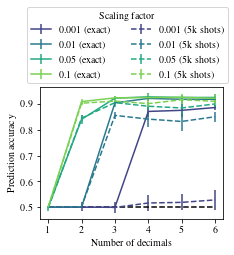

In [5]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

metric_to_plot = 'test_score'

f, ax=plt.subplots(figsize=(2*6.92654/4, 2*6.92654/4))

# evo_times = list(sorted(set(df_all_limited_precision_no_sampling['evo_time'])))
evo_times = [0.001, 0.01, 0.05, 0.1]

for idx, evo_time in enumerate(evo_times):
    to_plot = df_all_limited_precision_no_sampling[df_all_limited_precision_no_sampling['evo_time'] == evo_time]
    x = sorted(set(to_plot['decimals']))
    y = [to_plot[
        to_plot['decimals'] == decimal
    ][metric_to_plot].mean() for decimal in x]
    err = [to_plot[
        to_plot['decimals'] == decimal
    ][metric_to_plot].std() for decimal in x]
    ax.errorbar(
        x,y,
        yerr=err,
        label=f"{evo_time} (exact)",
        color=sns.color_palette("viridis",len(evo_times))[idx]
    )   

    
for idx, evo_time in enumerate(evo_times):
    to_plot = df_all_limited_precision_sampling[df_all_limited_precision_sampling['evo_time'] == evo_time]
    x = sorted(set(to_plot['decimals']))
    y = [to_plot[
        to_plot['decimals'] == decimal
    ][metric_to_plot].mean() for decimal in x]
    err = [to_plot[
        to_plot['decimals'] == decimal
    ][metric_to_plot].std() for decimal in x]
    ax.errorbar(
        x,y,
        yerr=err,
        label=f"{evo_time} (5k shots)",
        linestyle='dashed',
        color=sns.color_palette("viridis",len(evo_times))[idx]
    )
    

ax.hlines(y=0.5, xmin=1, xmax=6, 
             color='k', linestyle='dashed')

# Shrink current axis's height by 20% on the top
box = ax.get_position()
ax.set_position([box.x0+box.width*0.05, box.y0,
                 box.width*0.95, box.height * 0.7])
plt.legend(ncol=2, title='Scaling factor', bbox_to_anchor=(1.05, 1.65))

ax.set_ylabel(pretty_print_dict[metric_to_plot])
ax.set_xlabel('Number of decimals')
# plt.tight_layout()
plt.savefig('finite_precision_and_sampling.pdf')
plt.show()

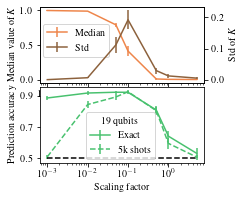

In [6]:
f, ax=plt.subplots(2,1,figsize=(2*6.92654/4, 2*6.92654/4.5))

palette = sns.color_palette("viridis",23)

dim=19

# top plot

to_plot = df_all_no_sampling[
    (df_all_no_sampling['dataset_dim'] == dim)
]

to_plot['median_ktrain_value'] = to_plot.apply(lambda row: np.median(get_lower_triangle_one(row['qkern_matrix_train'])), axis=1)
to_plot['std_ktrain_value'] = to_plot.apply(lambda row: np.std(get_lower_triangle_one(row['qkern_matrix_train'])), axis=1)

metric_to_plot = 'median_ktrain_value'

x = sorted(set(to_plot['evo_time']))
y = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].mean() for evo_time in x]
err = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].std() for evo_time in x]
ln1 = ax[0].errorbar(
    x,y,
    yerr=err,
    label="Median", 
    color=sns.color_palette("muted")[1]
)
ax[0].set_xscale("log")  
ax[0].set_ylabel("Median value of $K$")

metric_to_plot = 'std_ktrain_value'

box = ax[0].get_position()
ax[0].set_position([box.x0+box.width*0.05, box.y0,
                 box.width*0.85, box.height])
ax2=ax[0].twinx()

x = sorted(set(to_plot['evo_time']))
y = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].mean() for evo_time in x]
err = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].std() for evo_time in x]
ln2 = ax2.errorbar(
    x,y,
    yerr=err,
    label="Std", 
    color=sns.color_palette("muted")[5]
)
ax2.set_ylabel("Std of $K$")
box = ax2.get_position()
ax2.set_position([box.x0+box.width*0.05, box.y0,
                 box.width*0.85, box.height])

ax[0].legend(handles=[ln1,ln2], loc='upper center', 
            bbox_to_anchor=(0.22, 0.84))

# bottom plot

metric_to_plot = 'test_score'

to_plot = df_all_no_sampling[
    (df_all_no_sampling['dataset_dim'] == dim)
]
x = sorted(set(to_plot['evo_time']))
y = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].mean() for evo_time in x]
err = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].std() for evo_time in x]
ax[1].errorbar(
    x,y,
    yerr=err,
    label="Exact", 
    color=palette[dim-3]
)

to_plot = df_all_sampling[
    (df_all_sampling['dataset_dim'] == dim)
]
x = sorted(set(to_plot['evo_time']))
y = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].mean() for evo_time in x]
err = [to_plot[
    to_plot['evo_time'] == evo_time
][metric_to_plot].std() for evo_time in x]
ax[1].errorbar(
    x,y,
    yerr=err,
    label="5k shots",
    linestyle='dashed',
    color=palette[dim-3]
)

ax[1].set_yticks([0.5, 0.7, 0.9])

ax[1].hlines(y=0.5, xmin=0.001, xmax=5, 
                 color='k', linestyle='dashed')

box = ax[1].get_position()
ax[1].set_position([box.x0+box.width*0.05, box.y0+box.height*0.15,
                 box.width*0.85, box.height])


ax[1].set_xscale("log")    
ax[1].set_xlabel('Scaling factor')
ax[1].set_ylabel(pretty_print_dict[metric_to_plot])
ax[1].legend(title='19 qubits', loc='upper center', 
            bbox_to_anchor=(0.49, 0.74))
plt.savefig('full_precision_sampling.pdf')